# Testing Refactored AtomicSystem Class

This notebook demonstrates the **simplified and modular** refactored atomic system class.

## Key Improvements:
- **Separation of concerns**: Core system, coupling, geometry, and builders are separate
- **Consistent units**: Everything internal in fs⁻¹, with cm⁻¹ interface methods
- **No special cases**: Unified logic for 1, 2, or N atoms
- **Simple caching**: No complex @cached_property management
- **Factory functions**: Easy creation with `create_single_atom()`, `create_dimer()`, etc.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Import refactored classes
from qspectro2d.core.atomic_system.system_class_refactored import (
    AtomicSystem, SystemBuilder, CouplingMatrix, 
    LinearGeometry, CylindricalGeometry,
    create_single_atom, create_dimer, create_linear_chain
)

# Plotting setup
from plotstyle import COLORS, MARKERS, LINE_STYLES, init_style
init_style()

### Helper function for displaying system info
def show_system_info(title: str, builder: SystemBuilder):
    """Display comprehensive info about a SystemBuilder."""
    print(f"\n=== {title} ===")
    
    # Basic system parameters
    system = builder.system
    print(f"n_atoms: {system.n_atoms}")
    print(f"frequencies (cm⁻¹): {system.frequencies_cm}")
    print(f"dipole moments: {system.dipole_moments}")
    print(f"max_excitation: {system.max_excitation}")
    print(f"basis dimension: {builder.basis.dimension}")
    
    # Coupling matrix
    coupling_cm = builder.coupling.matrix_cm
    if np.any(coupling_cm != 0):
        print(f"coupling matrix (cm⁻¹):\n{coupling_cm}")
    
    # Hamiltonian (for small systems)
    if system.n_atoms <= 8:
        H = builder.build_hamiltonian()
        print(f"Hamiltonian matrix (ħ factored out):\n{H.tidyup().full().real}")
    
    # Eigenvalues
    evals, evecs = builder.get_eigenstates()
    print(f"eigenvalues (fs⁻¹): {evals}")
    
    return builder

## 1. Single Atom System

The simplest case - just one atom with a transition frequency.

In [14]:
# Single atom using factory function
single_atom = create_single_atom(freq_cm=16000.0, dipole=1.0)
show_system_info("Single Atom", single_atom);


=== Single Atom ===
n_atoms: 1
frequencies (cm⁻¹): [16000.]
dipole moments: [1.]
max_excitation: 1
basis dimension: 2
Hamiltonian matrix (ħ factored out):
[[0.         0.        ]
 [0.         3.01391833]]
eigenvalues (fs⁻¹): [0.         3.01391833]


## 2. Two-Atom Systems (Dimers)

Compare single vs double excitation manifolds.

In [3]:
# Dimer with single excitation manifold
dimer_single = create_dimer(
    freq1_cm=16500.0, 
    freq2_cm=15650.0, 
    coupling_cm=10.0,
    dipole1=1.0, 
    dipole2=1.2,
    max_excitation=1
)
show_system_info("Dimer (Single Excitation)", dimer_single)

# Calculate mixing angle for dimer (helper function)
def compute_mixing_angle(builder: SystemBuilder):
    """Compute mixing angle θ for two-atom system."""
    if builder.system.n_atoms != 2:
        return None
    
    freqs = builder.system.frequencies
    detuning = freqs[0] - freqs[1]  # Δ in fs⁻¹
    coupling = builder.coupling.matrix[0,1]  # J in fs⁻¹
    
    theta = 0.5 * np.arctan2(2 * coupling, detuning)
    return theta

theta = compute_mixing_angle(dimer_single)
print(f"Mixing angle θ: {theta:.4f} rad ({np.degrees(theta):.2f}°)")


=== Dimer (Single Excitation) ===
n_atoms: 2
frequencies (cm⁻¹): [16500. 15650.]
dipole moments: [1.  1.2]
max_excitation: 1
basis dimension: 3
coupling matrix (cm⁻¹):
[[ 0. 10.]
 [10.  0.]]
Hamiltonian matrix (ħ factored out):
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.10810328e+00 1.88369896e-03]
 [0.00000000e+00 1.88369896e-03 2.94798886e+00]]
eigenvalues (fs⁻¹): [0.         2.94796671 3.10812543]
Mixing angle θ: 0.0118 rad (0.67°)


In [4]:
# Same dimer but with double excitation manifold
dimer_double = create_dimer(
    freq1_cm=16500.0, 
    freq2_cm=15650.0, 
    coupling_cm=10.0,
    dipole1=1.0, 
    dipole2=1.2,
    max_excitation=2
)
show_system_info("Dimer (Double Excitation)", dimer_double)

theta2 = compute_mixing_angle(dimer_double)
print(f"Mixing angle θ: {theta2:.4f} rad ({np.degrees(theta2):.2f}°)")


=== Dimer (Double Excitation) ===
n_atoms: 2
frequencies (cm⁻¹): [16500. 15650.]
dipole moments: [1.  1.2]
max_excitation: 2
basis dimension: 4
coupling matrix (cm⁻¹):
[[ 0. 10.]
 [10.  0.]]
Hamiltonian matrix (ħ factored out):
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.10810328e+00 1.88369896e-03 0.00000000e+00]
 [0.00000000e+00 1.88369896e-03 2.94798886e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.05609214e+00]]
eigenvalues (fs⁻¹): [0.         2.94796671 3.10812543 6.05609214]
Mixing angle θ: 0.0118 rad (0.67°)


## 3. Three-Atom System with Custom Coupling

Demonstrate manual construction with custom parameters.

In [5]:
# Three atoms with different frequencies and double excitation
system_3 = AtomicSystem.from_cm(
    n_atoms=3,
    freqs_cm=[16000.0, 16500.0, 17000.0],
    dipole_moments=[1.0, 1.0, 1.0],
    max_excitation=2
)

# Set uniform coupling
coupling_3 = CouplingMatrix.from_cm(n_atoms=3, coupling_cm=1.0)

# Build the system
three_atoms = SystemBuilder(system_3, coupling_3)
show_system_info("Three Atoms (Manual Construction)", three_atoms);


=== Three Atoms (Manual Construction) ===
n_atoms: 3
frequencies (cm⁻¹): [16000. 16500. 17000.]
dipole moments: [1. 1. 1.]
max_excitation: 2
basis dimension: 7
coupling matrix (cm⁻¹):
[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]
Hamiltonian matrix (ħ factored out):
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.01391833e+00 1.88369896e-04 1.88369896e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88369896e-04 3.10810328e+00 1.88369896e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.88369896e-04 1.88369896e-04 3.20228822e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.12202160e+00 1.88369896e-04 1.88369896e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.88369896e-04 6.21620655e+00 1.88369896e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.88369896e-04 1.

## 4. Linear Chain with Geometric Coupling

Using the factory function that automatically computes 1/r³ couplings.

In [6]:
# 5-atom linear chain with dipole-dipole coupling
chain_5 = create_linear_chain(
    n_atoms=5,
    freq_cm=16000.0,  # All atoms same frequency
    coupling_cm=30.0,  # Base coupling strength
    spacing=1.0,       # Distance between atoms
    dipole=1.0,        # All dipoles same
    max_excitation=1
)

show_system_info("5-Atom Linear Chain", chain_5)

# Show the geometric positions
geometry = LinearGeometry(5, spacing=1.0)
positions = geometry.get_positions()
print(f"\nAtom positions:\n{positions}")


=== 5-Atom Linear Chain ===
n_atoms: 5
frequencies (cm⁻¹): [16000. 16000. 16000. 16000. 16000.]
dipole moments: [1. 1. 1. 1. 1.]
max_excitation: 1
basis dimension: 6
coupling matrix (cm⁻¹):
[[ 0.         30.          3.75        1.11111111  0.46875   ]
 [30.          0.         30.          3.75        1.11111111]
 [ 3.75       30.          0.         30.          3.75      ]
 [ 1.11111111  3.75       30.          0.         30.        ]
 [ 0.46875     1.11111111  3.75       30.          0.        ]]
Hamiltonian matrix (ħ factored out):
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.01391833e+00 5.65109687e-03 7.06387108e-04
  2.09299884e-04 8.82983885e-05]
 [0.00000000e+00 5.65109687e-03 3.01391833e+00 5.65109687e-03
  7.06387108e-04 2.09299884e-04]
 [0.00000000e+00 7.06387108e-04 5.65109687e-03 3.01391833e+00
  5.65109687e-03 7.06387108e-04]
 [0.00000000e+00 2.09299884e-04 7.06387108e-04 5.65109687e-03
  3.01391833e+

## 5. Cylindrical Geometry (Custom)

Create a more complex system with cylindrical arrangement.

In [7]:
# 12-atom cylindrical system (4 chains × 3 rings)
n_atoms = 12
n_rings = 3

# Create the system
system_cyl = AtomicSystem.from_cm(
    n_atoms=n_atoms,
    freqs_cm=[16000.0] * n_atoms,  # All same frequency
    dipole_moments=[1.0] * n_atoms,
    max_excitation=1
)

# Create cylindrical geometry and compute couplings
geometry_cyl = CylindricalGeometry(n_atoms=n_atoms, n_rings=n_rings, axial_spacing=1.0)
positions_cyl = geometry_cyl.get_positions()

# Compute distance-based coupling matrix
base_coupling_fs = 20.0 * 5.3e-3  # Convert cm⁻¹ to fs⁻¹ approximately
coupling_matrix_cyl = geometry_cyl.compute_coupling_matrix(
    base_strength=base_coupling_fs, 
    dipole_moments=system_cyl.dipole_moments
)

coupling_cyl = CouplingMatrix(n_atoms, coupling_matrix_cyl)
cylindrical_system = SystemBuilder(system_cyl, coupling_cyl)

show_system_info("12-Atom Cylindrical System", cylindrical_system)

print(f"\nGeometry info:")
print(f"n_chains: {geometry_cyl.n_chains}")
print(f"n_rings: {geometry_cyl.n_rings}")
print(f"positions shape: {positions_cyl.shape}")


=== 12-Atom Cylindrical System ===
n_atoms: 12
frequencies (cm⁻¹): [16000. 16000. 16000. 16000. 16000. 16000. 16000. 16000. 16000. 16000.
 16000. 16000.]
dipole moments: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
max_excitation: 1
basis dimension: 13
coupling matrix (cm⁻¹):
[[  0.         562.722614    70.34032675 562.722614   198.95248814
   50.3314407  198.95248814 108.29601756  38.2884242  562.722614
  198.95248814  50.3314407 ]
 [562.722614     0.         562.722614   198.95248814 562.722614
  198.95248814 108.29601756 198.95248814 108.29601756 198.95248814
  562.722614   198.95248814]
 [ 70.34032675 562.722614     0.          50.3314407  198.95248814
  562.722614    38.2884242  108.29601756 198.95248814  50.3314407
  198.95248814 562.722614  ]
 [562.722614   198.95248814  50.3314407    0.         562.722614
   70.34032675 562.722614   198.95248814  50.3314407  198.95248814
  108.29601756  38.2884242 ]
 [198.95248814 562.722614   198.95248814 562.722614     0.
  562.722614   198.952488

## 6. Visualization: Coupling Matrix and 3D Positions

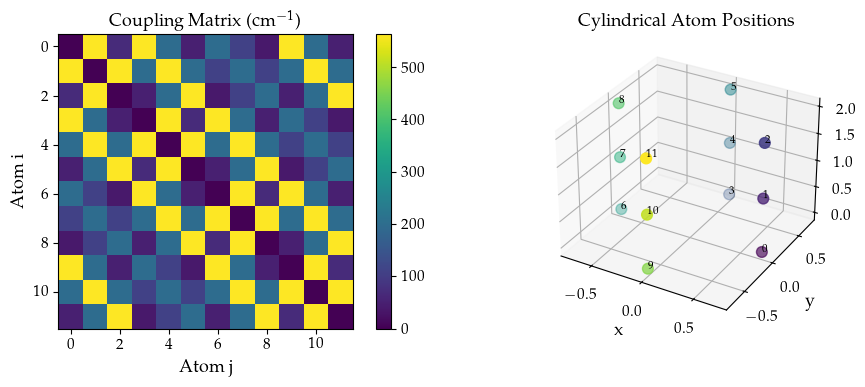

In [ ]:
### Visualization of cylindrical system
from plotstyle.style import save_fig


fig = plt.figure(figsize=(12, 4))

# Coupling matrix heatmap
ax1 = fig.add_subplot(1, 2, 1)
coupling_display = cylindrical_system.coupling.matrix_cm
im = ax1.imshow(coupling_display, cmap='viridis')
ax1.set_title("Coupling Matrix (cm$^{-1}$)")
ax1.set_xlabel("Atom j")
ax1.set_ylabel("Atom i")
plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

# 3D positions
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
pos = positions_cyl
ax2.scatter(pos[:, 0], pos[:, 1], pos[:, 2], 
           c=np.arange(len(pos)), cmap='viridis', s=60)

# Label atoms
for idx, (x, y, z) in enumerate(pos):
    ax2.text(x, y, z, f"{idx}", fontsize=8)
    
ax2.set_title("Cylindrical Atom Positions")
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
save_fig("cylindrical_system_positions.png")

## 7. Energy Spectrum Comparison

Compare eigenvalue spectra across different systems.

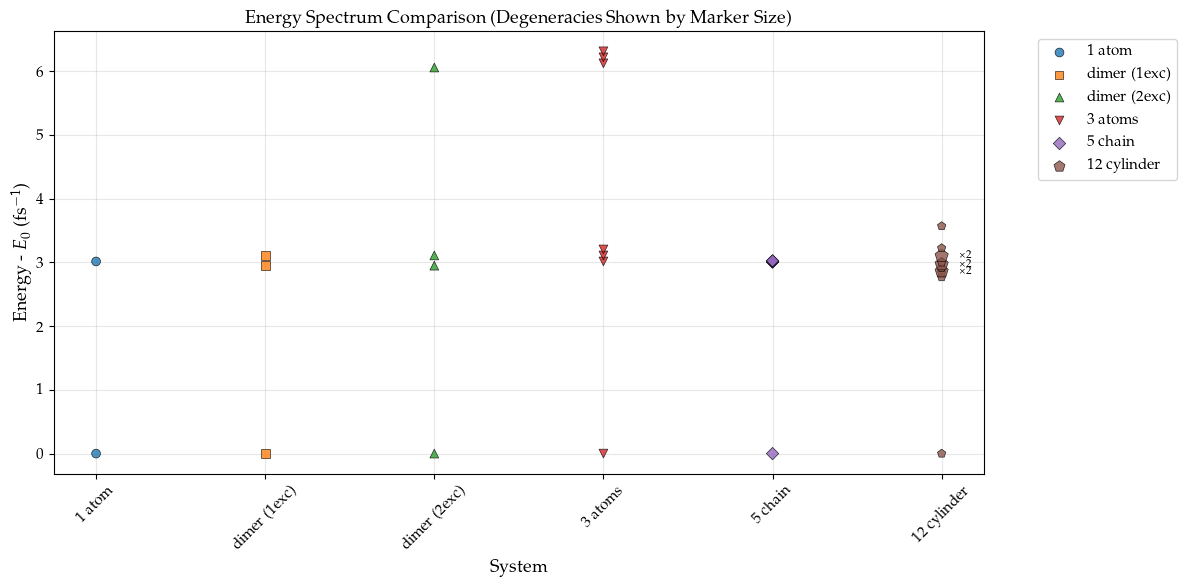

In [12]:
# Collect all systems for comparison
systems_comparison = {
    "1 atom": single_atom,
    "dimer (1exc)": dimer_single,
    "dimer (2exc)": dimer_double,
    "3 atoms": three_atoms,
    "5 chain": chain_5,
    "12 cylinder": cylindrical_system,
}

def group_degenerate_levels(eigenvals: np.ndarray, tolerance: float = 1e-10):
    """Group nearly-equal eigenvalues and count degeneracies."""
    sorted_vals = np.sort(eigenvals)
    unique_vals = []
    degeneracies = []
    
    for val in sorted_vals:
        if not unique_vals or abs(val - unique_vals[-1]) > tolerance:
            unique_vals.append(val)
            degeneracies.append(1)
        else:
            degeneracies[-1] += 1
    
    return np.array(unique_vals), np.array(degeneracies)

# Create spectrum plot
plt.figure(figsize=(12, 6))

for x_pos, (label, system_builder) in enumerate(systems_comparison.items()):
    evals, _ = system_builder.get_eigenstates()
    
    # Shift so ground state is at zero
    evals_shifted = evals - evals.min()
    
    # Group degenerate levels
    unique_evals, degeneracies = group_degenerate_levels(evals_shifted)
    
    # Choose colors and markers
    color = COLORS[x_pos % len(COLORS)]
    marker = MARKERS[x_pos % len(MARKERS)]
    
    # Marker size indicates degeneracy
    sizes = 40 + 60 * (degeneracies - 1)
    
    plt.scatter(
        np.full_like(unique_evals, x_pos, dtype=float),
        unique_evals,
        s=sizes,
        color=color,
        marker=marker,
        edgecolors='black',
        linewidths=0.5,
        label=label,
        alpha=0.8,
        zorder=3
    )
    
    # Annotate degeneracies > 1
    for eval_val, deg in zip(unique_evals, degeneracies):
        if deg > 1:
            plt.text(x_pos + 0.1, eval_val, f"×{deg}", 
                    va='center', ha='left', fontsize=8)

plt.ylabel(r'Energy - $E_0$ (fs$^{-1}$)')
plt.xlabel('System')
plt.title('Energy Spectrum Comparison (Degeneracies Shown by Marker Size)')
plt.xticks(range(len(systems_comparison)), list(systems_comparison.keys()), rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 8. Serialization and Reconstruction

Demonstrate saving and loading system parameters.

In [ ]:
# Test serialization with the dimer system
print("=== Serialization Test ===")

# Serialize the core system
original_system = dimer_double.system
serialized_data = original_system.to_dict()
print(f"Serialized data: {serialized_data}")

# Reconstruct the system
reconstructed_system = AtomicSystem.from_dict(serialized_data)
print(f"\nReconstruction successful: {type(reconstructed_system)}")

# Verify parameters match
print(f"Frequencies match: {np.allclose(original_system.frequencies, reconstructed_system.frequencies)}")
print(f"Dipoles match: {np.allclose(original_system.dipole_moments, reconstructed_system.dipole_moments)}")
print(f"n_atoms match: {original_system.n_atoms == reconstructed_system.n_atoms}")
print(f"max_excitation match: {original_system.max_excitation == reconstructed_system.max_excitation}")

# Rebuild with same coupling and compare eigenvalues
reconstructed_builder = SystemBuilder(reconstructed_system, dimer_double.coupling)
orig_evals, _ = dimer_double.get_eigenstates()
recon_evals, _ = reconstructed_builder.get_eigenstates()

print(f"Eigenvalues match: {np.allclose(orig_evals, recon_evals)}")

## 9. Performance and Memory Comparison

Quick check of computational efficiency.

In [ ]:
import time
import sys

# Test performance for larger system
print("=== Performance Test ===")

# Create a moderately large system
n_large = 20
start_time = time.time()

large_system = AtomicSystem.from_cm(
    n_atoms=n_large,
    freqs_cm=[16000.0 + i*10 for i in range(n_large)],  # Slight detuning
    dipole_moments=[1.0] * n_large,
    max_excitation=1
)

large_coupling = CouplingMatrix.from_cm(n_large, coupling_cm=5.0)
large_builder = SystemBuilder(large_system, large_coupling)

setup_time = time.time() - start_time

# Time Hamiltonian construction
start_time = time.time()
H_large = large_builder.build_hamiltonian()
hamiltonian_time = time.time() - start_time

# Time eigenvalue calculation
start_time = time.time()
evals_large, evecs_large = large_builder.get_eigenstates()
eigenvalue_time = time.time() - start_time

print(f"System setup time: {setup_time:.4f} s")
print(f"Hamiltonian construction: {hamiltonian_time:.4f} s")
print(f"Eigenvalue calculation: {eigenvalue_time:.4f} s")
print(f"Total dimension: {large_builder.basis.dimension}")
print(f"Hamiltonian shape: {H_large.shape}")

# Test caching
start_time = time.time()
H_cached = large_builder.build_hamiltonian()  # Should be instant (cached)
cache_time = time.time() - start_time
print(f"Cached Hamiltonian access: {cache_time:.6f} s")

## Summary: Refactored vs Original

### ✅ **Improvements in Refactored Version:**

1. **Cleaner API**: Factory functions like `create_dimer()` vs complex constructor
2. **Separated concerns**: Geometry, coupling, and Hamiltonian are separate classes
3. **Consistent units**: Internal fs⁻¹, with cm⁻¹ interface methods
4. **No special cases**: Same code path for 1, 2, or N atoms
5. **Simple caching**: Easy to understand and debug
6. **Extensible**: Easy to add new geometries or coupling types

### 🔧 **Usage Patterns:**

```python
# Quick systems with factory functions
system = create_dimer(freq1_cm=16000, freq2_cm=15500, coupling_cm=50)

# Custom systems with manual construction
core_system = AtomicSystem.from_cm(n_atoms=3, freqs_cm=[...], dipole_moments=[...])
coupling = CouplingMatrix.from_cm(3, coupling_cm=10.0)
builder = SystemBuilder(core_system, coupling)

# Access properties
H = builder.build_hamiltonian()
dipole_op = builder.build_dipole_operator()
evals, evecs = builder.get_eigenstates()
```